Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [39]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [40]:
def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells


def add_wells_features(wells, features_for_detrend):
    wells_new = []
    for well in wells:
        wells_new.append(detrend(well, features_for_detrend))
    return wells_new


def detrend(df, features_for_detrend):
    undefined_value = -9999

    def check_correct_md(df_):
        def is_md_correct(row, md, md_last):
            difference = row[md_last] - row[md]
            if (difference - 0.2) > 0.001:
                display(row)
            return row

        copy_df_ = df_.copy()
        copy_df_['MD_last'] = copy_df_['MD'].shift(-1)
        copy_df_.apply(
            lambda row: is_md_correct(row, 'MD', 'MD_last'), axis=1)
        del copy_df_['MD_last']

    def corrector_detrend(row, name_base, name_detrend):
        if row[name_base] < -999:
            return undefined_value
        if row[name_base] > 500:
            return undefined_value
        if row[name_detrend] > 999:
            return undefined_value
        if row[name_detrend] < -999:
            return undefined_value
        return row[name_detrend]

    import math
    def corrector_nulls(value):
        if math.isnan(value):
            return undefined_value
        if math.isinf(value):
            return undefined_value
        if value == 'NaN':
            return undefined_value
        return value

    def remove_trend(serials):
        from scipy import signal
        return signal.detrend(serials)

    check_correct_md(df.copy())
    copy_df = df.copy()

    for feature in features_for_detrend:
        prefix = '_det'
        copy_df[feature + prefix] = copy_df[feature] - copy_df[feature].shift(-1)
        copy_df[feature] = copy_df[feature].apply(corrector_nulls)
        copy_df[feature + prefix] = remove_trend(copy_df[feature])
        copy_df[feature + '_detrend'] = copy_df.apply(
            lambda row: corrector_detrend(row, feature, feature + prefix), axis=1)
        del copy_df[feature + prefix]
    return copy_df


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    # del feature['datasetName']
    # feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["GR"] >= -999]
    feature = feature[feature["SP"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    #feature["SP_"] = feature["SP"].apply(np.int64)
    #feature["SP_"] = savitzky_golay(feature["SP_"].values, 22, 3)
    return feature


name_dataset = 'DATATRAIN18+LAYER.csv'  # 'DATATRAINSHORTSTANDLAY.csv'
wells_base_df = get_for_learn_clean_df(pd.read_csv(name_dataset, sep=';'))
display(wells_base_df.describe())
wells_samples_df = get_well_dfs(wells_base_df)
wells_add_detrends_df = add_wells_features(wells_samples_df, ['SP'])
display(wells_base_df[wells_base_df['Facies'] > -1].describe())

MD            BK        Facies            GR           LIT  \
count  81906.000000  78294.000000  81906.000000  81906.000000  81906.000000   
mean    2137.625527  -2510.093415  -9666.529461     10.702307  -8059.370889   
std      397.628930   4354.708474   1793.207271      6.943744   3954.292496   
min      707.000000  -9999.000000  -9999.000000      0.680000  -9999.000000   
25%     1877.800000  -9999.000000  -9999.000000      7.840000  -9999.000000   
50%     2159.600000      5.840000  -9999.000000      9.778500  -9999.000000   
75%     2433.600000      8.509500  -9999.000000     12.112000  -9999.000000   
max     3093.000000  22739.520000     12.000000    142.370000      6.000000   

               NKTB            SP  
count  81906.000000  81906.000000  
mean       3.607056    106.134190  
std        0.907451     38.822690  
min        0.970000     -1.588982  
25%        3.037409     81.430000  
50%        3.580072    104.451000  
75%        4.066400    122.000000  
max       15.351170    578.255500

MD           BK       Facies           GR          LIT  \
count  2722.000000  2548.000000  2722.000000  2722.000000  2722.000000   
mean   2636.231962    11.046530     5.163115     9.625897  -130.025349   
std     151.193430    11.783037     2.518843     2.901482  1142.747944   
min    2507.600000     3.414000     0.000000     1.720000 -9999.000000   
25%    2553.200000     6.773750     5.000000     7.470000     1.000000   
50%    2576.200000     8.600000     5.000000     9.321000     1.000000   
75%    2611.750000    11.700000     7.000000    11.460000     4.000000   
max    3086.200000   231.100000    12.000000    18.340000     5.000000   

              NKTB           SP  
count  2722.000000  2722.000000  
mean      4.402206   112.327355  
std       0.809052    33.980272  
min       2.264484    49.395160  
25%       3.850000    92.013475  
50%       4.285461   107.611950  
75%       4.807067   124.457325  
max       8.589926   207.469100

In [41]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def get_well_with_distance_features__(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'SP')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'SP')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy


def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
            if part[name].max() == part[name].min():
                part['std_' + new_feature_prefix + name] = 0
            else:
                part['std_' + new_feature_prefix + name] = part[name].std()
            part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()
        well_copy = get_well_with_distance_features__(well_copy)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


well_with_features = get_well_with_features_df(wells_add_detrends_df, ['SP'], [0.1])
for_ml_preprocessing = pd.concat(well_with_features)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0


In [58]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
def standarize_feature(train_df, cols, test_df=0):
    def save_simple_model(model, name):
        import pickle
        from sklearn.externals import joblib
        with open(name, 'wb') as f:
             pickle.dump(model, f)
            
    def load_simple_model(name):
        from sklearn.externals import joblib
        test_load_model = joblib.load(name)
        return test_load_model
    
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    for col in cols:
        train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1,1).astype(np.float32))
        #if type(test_df)!=int:
            #test_df[col] = scaler.transform(test_df[col].values.reshape(-1,1).astype(np.float32))
    save_simple_model(scaler, 'RobustScaler')
    return None

def get_well_with_features_df_rebost(wells):
    wells_return = []
    wells_nulls = []
    for well in wells:
        well_copy = well.copy().dropna()
        if not well_copy.empty:
            standarize_feature(well_copy, [i for i in well_copy.columns if i!= 'wellName' 
                                       and i!='datasetName'  
                                       and i!='MD'
                                       and i!='LAYER'
                                       and i!='LIT'
                                       and i!='Facies'])
            wells_return.append(well_copy)
    print(len(wells_nulls))
    return wells_return

#well_with_features_ = get_well_with_features_df_rebost(well_with_features)
#for_ml_preprocessing = pd.concat(well_with_features_)

In [59]:
well_with_features

[     wellName datasetName      MD    BK  Facies     GR  LAYER   LIT      NKTB  \
 0     spk1521   TrainLogs  2011.0  4.42   -9999  13.60  -9999 -9999  2.968678   
 1     spk1521   TrainLogs  2011.2  4.30   -9999  13.51  -9999 -9999  2.937724   
 2     spk1521   TrainLogs  2011.4  4.31   -9999  13.17  -9999 -9999  2.973814   
 3     spk1521   TrainLogs  2011.6  4.28   -9999  13.03  -9999 -9999  2.989185   
 4     spk1521   TrainLogs  2011.8  4.26   -9999  12.94  -9999 -9999  2.968678   
 5     spk1521   TrainLogs  2012.0  4.41   -9999  12.64  -9999 -9999  3.024832   
 6     spk1521   TrainLogs  2012.2  4.50   -9999  12.61  -9999 -9999  3.055148   
 7     spk1521   TrainLogs  2012.4  5.00   -9999  12.93  -9999 -9999  3.105200   
 8     spk1521   TrainLogs  2012.6  4.75   -9999  13.44  -9999 -9999  3.139893   
 9     spk1521   TrainLogs  2012.8  4.59   -9999  13.41  -9999 -9999  3.115140   
 10    spk1521   TrainLogs  2013.0  4.63   -9999  13.23  -9999 -9999  3.134954   
 11    spk1521  

In [60]:
for_ml_preprocessing.describe()

MD            BK        Facies            GR           LIT  \
count  81906.000000  78294.000000  81906.000000  81906.000000  81906.000000   
mean    2137.625527  -2510.093415  -9666.529461     10.702307  -8059.370889   
std      397.628930   4354.708474   1793.207271      6.943744   3954.292496   
min      707.000000  -9999.000000  -9999.000000      0.680000  -9999.000000   
25%     1877.800000  -9999.000000  -9999.000000      7.840000  -9999.000000   
50%     2159.600000      5.840000  -9999.000000      9.778500  -9999.000000   
75%     2433.600000      8.509500  -9999.000000     12.112000  -9999.000000   
max     3093.000000  22739.520000     12.000000    142.370000      6.000000   

               NKTB            SP    SP_detrend   GR_last_3.0   SP_last_3.0  \
count  81906.000000  81906.000000  81906.000000  81666.000000  81666.000000   
mean       3.607056    106.134190     -1.394329     10.708772    106.100047   
std        0.907451     38.822690    117.938970      6.951721     38.613390   
min        0.970000     -1.588982  -9999.000000      0.680000     -1.588982   
25%        3.037409     81.430000    -10.774719      7.848000     81.439707   
50%        3.580072    104.451000      6.923657      9.780000    104.467950   
75%        4.066400    122.000000     14.188429     12.120000    121.987200   
max       15.351170    578.255500    243.898577    142.370000    578.255500   

       ...  BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  \
count  ...  77394.000000    80946.000000  80706.000000  80706.000000   
mean   ...  -2539.982338        3.603291     10.734602    106.179212   
std    ...   4370.226568        0.908013      6.985074     38.542711   
min    ...  -9999.000000        0.970000      0.680000     -1.588982   
25%    ...  -9999.000000        3.032778      7.860000     81.620190   
50%    ...      5.800000        3.576388      9.800000    104.511050   
75%    ...      8.450000        4.062021     12.160000    121.987200   
max    ...  19841.920000       15.351170    142.370000    578.255500   

       BK_last_15.0  NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count  77169.000000    80706.000000  80706.000000  80706.000000  77169.000000   
mean   -2505.568768        3.617209     10.709470    105.925879  -2547.437770   
std     4352.296823        0.907806      6.982329     38.510602   4374.407908   
min    -9999.000000        0.970000      1.320000     -1.588982  -9999.000000   
25%    -9999.000000        3.050000      7.846000     81.262025  -9999.000000   
50%        5.850000        3.590325      9.771000    104.320000      5.800000   
75%        8.520000        4.075108     12.100000    121.825050      8.420000   
max    22739.520000       15.351170    142.370000    407.131500  19841.920000   

       NKTB_next_15.0  
count    80706.000000  
mean         3.602065  
std          0.908034  
min          0.970000  
25%          3.030878  
50%          3.574859  
75%          4.061550  
max         15.351170  

[8 rows x 48 columns]

In [61]:
for_ml_preprocessing[for_ml_preprocessing['Facies'] > -1].describe()

MD           BK       Facies           GR          LIT  \
count  2722.000000  2548.000000  2722.000000  2722.000000  2722.000000   
mean   2636.231962    11.046530     5.163115     9.625897  -130.025349   
std     151.193430    11.783037     2.518843     2.901482  1142.747944   
min    2507.600000     3.414000     0.000000     1.720000 -9999.000000   
25%    2553.200000     6.773750     5.000000     7.470000     1.000000   
50%    2576.200000     8.600000     5.000000     9.321000     1.000000   
75%    2611.750000    11.700000     7.000000    11.460000     4.000000   
max    3086.200000   231.100000    12.000000    18.340000     5.000000   

              NKTB           SP   SP_detrend  GR_last_3.0  SP_last_3.0  ...  \
count  2722.000000  2722.000000  2722.000000  2707.000000  2707.000000  ...   
mean      4.402206   112.327355    -4.618361     9.776795   112.921306  ...   
std       0.809052    33.980272    13.791361     2.920534    34.129905  ...   
min       2.264484    49.395160   -57.621411     1.720000    49.395160  ...   
25%       3.850000    92.013475    -9.040552     7.611000    93.467265  ...   
50%       4.285461   107.611950    -1.393158     9.510000   108.068800  ...   
75%       4.807067   124.457325     4.217732    11.686000   124.137850  ...   
max       8.589926   207.469100    65.309533    18.190000   207.469100  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2548.000000     2722.000000   2606.000000   2606.000000   2432.000000   
mean     101.100124        3.991374     10.048678    114.886680      9.469119   
std      271.436404        1.039265      2.791376     33.858484      7.560894   
min    -2155.509000        1.170589      2.560000     49.395160      3.490000   
25%        7.373750        3.415615      7.920000     94.145713      6.419250   
50%       11.034500        4.003883      9.840000    110.322600      7.900000   
75%       44.737500        4.576056     11.917750    127.396075      9.941250   
max     3731.080000        8.589926     18.190000    201.439000    124.257000   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2606.000000   2722.000000   2722.000000   2548.000000   
mean         4.250307     26.763913    114.249646    126.529743   
std          0.739296     27.779530     36.570106    290.610153   
min          2.040000      1.720000     50.765660  -2155.509000   
25%          3.788655      8.792500     94.719630      7.717250   
50%          4.181107     12.212500    107.895200     12.815000   
75%          4.633521     42.086000    126.424750    125.778499   
max          8.054000    142.370000    207.469100   3731.080000   

       NKTB_next_15.0  
count     2722.000000  
mean         3.854600  
std          1.111577  
min          1.170589  
25%          3.070240  
50%          3.900522  
75%          4.516258  
max          8.589926  

[8 rows x 48 columns]

In [62]:


def get_features_filtering(wells):
    well_copy = wells.copy()
    del well_copy['LAYER']
    del well_copy['datasetName']
    #del well_copy['BK']
    #del well_copy['NKTB']
    well_copy = well_copy[well_copy['Facies'] > -1]
    for name_feature in well_copy.columns:
        if name_feature != 'wellName' and name_feature != 'Facies':
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()

def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class


for_ml_with_features = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())

features = get_for_learn_featres(for_ml_with_features)
target_facies = get_for_learn_target_class(for_ml_with_features)
display(features)

MD
BK
GR
LIT
NKTB
SP
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


MD           BK       Facies           GR          LIT  \
count  2403.000000  2403.000000  2403.000000  2403.000000  2403.000000   
mean   2616.861506    11.062954     5.228048     9.636298     2.274241   
std     135.757489    11.924375     2.570815     2.965540     1.530739   
min    2507.600000     3.414000     0.000000     1.720000     1.000000   
25%    2551.000000     6.772500     5.000000     7.400000     1.000000   
50%    2573.400000     8.630000     5.000000     9.310000     1.000000   
75%    2602.900000    11.792500     7.000000    11.519500     4.000000   
max    3060.400000   231.100000    12.000000    18.190000     5.000000   

              NKTB           SP   SP_detrend  GR_last_3.0  SP_last_3.0  ...  \
count  2403.000000  2403.000000  2403.000000  2403.000000  2403.000000  ...   
mean      4.423657   111.541328    -5.701073     9.762737   112.362015  ...   
std       0.807342    35.567450    13.705098     2.979551    35.727754  ...   
min       2.264484    49.395160   -57.621411     1.720000    49.395160  ...   
25%       3.864249    88.463615   -10.569248     7.565000    89.162515  ...   
50%       4.323448   105.295200    -2.030636     9.410000   106.295200  ...   
75%       4.835265   125.498350     3.807133    11.711500   125.684950  ...   
max       8.589926   207.469100    16.839488    18.190000   207.469100  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2403.000000     2403.000000   2403.000000   2403.000000   2403.000000   
mean      99.849722        4.024052      9.994558    114.448155      9.503864   
std      265.040570        1.070762      2.859379     34.949821      7.599012   
min        0.625000        1.170589      2.560000     49.395160      3.490000   
25%        7.453000        3.423472      7.800000     91.987175      6.442500   
50%       11.100000        4.064234      9.720000    108.974900      7.950000   
75%       50.465000        4.630000     11.934000    127.570000     10.000000   
max     3731.080000        8.589926     18.190000    201.439000    124.257000   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2403.000000   2403.000000   2403.000000   2403.000000   
mean         4.265358     27.042665    114.781368    127.987381   
std          0.756515     27.875250     37.544872    287.550018   
min          2.040000      1.720000     52.900000      0.625000   
25%          3.797962      8.880000     93.354835      7.900000   
50%          4.201482     12.636000    107.188400     13.200000   
75%          4.664127     42.315000    126.940000    131.805000   
max          8.054000    142.370000    207.469100   3731.080000   

       NKTB_next_15.0  
count     2403.000000  
mean         3.870303  
std          1.152044  
min          1.170589  
25%          3.001171  
50%          3.929869  
75%          4.577076  
max          8.589926  

[8 rows x 48 columns]

BK      GR      NKTB        SP  SP_detrend  GR_last_3.0  \
5044     8.040  12.410  4.431441  103.8600  -18.142271        9.800   
5045     7.940  11.610  4.680739  103.7900  -18.217047        9.450   
5046     9.900  11.460  4.794586  103.5300  -18.481823        9.340   
5047    13.320  11.200  4.816397  104.6900  -17.326600        9.360   
5048    14.990  11.380  4.809134  106.9300  -15.091376        9.510   
5049    17.660  12.050  4.827276  107.6500  -14.376152        9.860   
5050    15.780  12.880  4.702928  109.1200  -12.910928       10.050   
5051    10.720  14.640  4.454518  110.9100  -11.125705        9.920   
5052     8.010  16.860  4.171620  111.7100  -10.330481        9.660   
5053     9.350  17.110  4.159534  108.6500  -13.395257        9.570   
5054     9.820  15.290  4.392788  105.5000  -16.550033        9.810   
5055     9.100  13.680  4.492788  103.9600  -18.094810       10.460   
5056     9.610  13.100  4.545977  101.8300  -20.229586       11.380   
5057    11.600  12.050  4.598722  101.2800  -20.784362       12.610   
5058    12.570  10.520  4.654756  100.8000  -21.269138       13.610   
5059    13.280   9.800  4.750749   99.7600  -22.313915       14.370   
5060    14.150   9.450  4.830898   99.7500  -22.328691       15.440   
5061    12.930   9.340  4.761736   99.7900  -22.293467       15.220   
5062    11.980   9.360  4.848981  100.3300  -21.758243       13.740   
5063    10.840   9.510  4.945802  101.3400  -20.753020       12.890   
5064     9.270   9.860  4.938677  103.1400  -18.957796       12.380   
5065     9.530  10.050  4.952920  103.3000  -18.802572       11.620   
5066    10.600   9.920  4.885002  103.0600  -19.047348       10.710   
5067    12.060   9.660  4.834518  104.9400  -17.172124        9.650   
5068    12.560   9.570  4.725043  106.6800  -15.436901        8.650   
5069    20.060   9.810  4.557316  108.1000  -14.021677        8.130   
5070    14.120  10.460  4.385028  108.8100  -13.316453        8.380   
5071     8.860  11.380  4.187695  110.4000  -11.731229        8.810   
5072     7.060  12.610  3.941676  113.0200   -9.116006        8.680   
5073     9.410  13.610  3.648751  115.2400   -6.900782        8.460   
...        ...     ...       ...       ...         ...          ...   
124790   5.283  10.071  4.341987  167.0245  -24.974590        9.815   
124791   4.637  11.358  4.386240  167.5197  -24.488612       10.284   
124792   4.512  11.900  4.473550  169.2248  -22.792734       10.326   
124793   4.417  12.967  4.124907  170.3850  -21.641756       10.198   
124794   4.653  15.165  4.597937  170.7572  -21.278778       10.202   
124795   5.797  14.940  4.704982  164.9543  -27.090900       10.450   
124796   6.978  12.808  4.801860  155.7985  -36.255922       11.928   
124797   6.774  10.800  4.727706  148.8216  -43.242044       13.056   
124798   5.999   9.724  4.704982  145.4668  -46.606066       13.634   
124799   6.757   8.709  4.233746  149.0440  -43.038088       12.646   
124800   8.227   7.761  4.893954  155.1481  -36.943210       11.686   
124801   9.271   7.378  5.353230  161.0703  -31.030232       12.223   
124802   8.311   8.456  5.278478  163.4244  -28.685354       13.268   
124803   6.595   9.536  4.754019  161.4796  -30.639376       13.701   
124804   5.384   9.445  4.467570  156.9438  -35.184398       13.306   
124805   5.895   9.815  4.373682  152.9669  -39.170520       13.337   
124806   5.853  10.284  4.339595  148.9061  -43.240542       14.148   
124807   5.611  10.326  4.612289  147.9332  -44.222664       14.281   
124808   4.840  10.198  4.486108  150.3494  -41.815686       12.215   
124809   4.792  10.202  4.406572  155.5576  -36.616708       11.253   
124810   4.393  10.450  4.037598  162.3457  -29.837830       11.583   
124811   4.716  11.928  4.433483  172.1509  -20.041852       10.954   
124812   5.128  13.056  4.317468  174.7020  -17.499974       10.830   
124813   5.069  13.634  4.919071  178.6012  -13.609996       10.335   
124814   5.004  12.646  3.819322  18

In [63]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
    #scores = cross_val_score(model, train, labels, cv=skf)
    #print("---cross_val_score---")
    #print("CV scores: {0}".format(scores))
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [64]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=10)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))

    scores = cross_val_score(model, train, labels, cv=skf)
    print("---cross_val_score---")
    print("CV scores: {0}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


def get_optimization_params(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    rmse = get_oprimization(ridge_model_cv, train, labels)
    return rmse


def get_oprimization(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    rmse = mean_squared_error(labels, predicted)
    return rmse


def get_best_model_ml(train, labels, rfe_count):
    model = RidgeClassifier(random_state=18, normalize=True)
    # train_data = Pool(train,  labels)

    # model = CatBoostClassifier(iterations=10,logging_level='Silent',class_weights=[0.9, 2])
    rfe = RFE(estimator=model, n_features_to_select=rfe_count)
    rfe = rfe.fit(train, labels)
    return rfe


def print_cross_val_predict(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    p_cross_val(ridge_model_cv, train, labels)
    print(ridge_model_cv.support_)
    print(sorted(zip(map(lambda x: round(x, 4), ridge_model_cv.ranking_), train.columns)))


def start_optimizer(train, labels):
    step_md = 4
    max_count = 250
    rmse_min = 50
    for rfe_count in range(50, max_count, step_md):
        rmse = get_optimization_params(train, labels, rfe_count)
        if rmse < rmse_min:
            rmse_min = rmse
            print('Rmse ' + str(rmse_min) + ' rfe_count ' + str(rfe_count))
            print_cross_val_predict(train, labels, rfe_count)

start_optimizer(features, target_facies)


Rmse 6.23304203079484 rfe_count 50
cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       1.00      0.15      0.26        86
           3       0.00      0.00      0.00        85
           5       0.60      0.89      0.72      1203
           7       0.55      0.55      0.55       581
           8       0.60      0.22      0.32       110
          12       0.00      0.00      0.00       105

   micro avg       0.59      0.59      0.59      2403
   macro avg       0.39      0.26      0.26      2403
weighted avg       0.50      0.59      0.52      2403

rmse 6.238868081564711


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---cross_val_score---
CV scores: [0.72540984 0.57201646 0.73662551 0.55186722 0.37759336 0.66945607
 0.41176471 0.58823529 0.6302521  0.64705882]
Accuracy: 0.59 (+/- 0.23)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[(1, 'BK'), (1, 'BK_last_12.0'), (1, 'BK_last_15.0'), (1, 'BK_last_3.0'), (1, 'BK_last_6.0'), (1, 'BK_last_9.0'), (1, 'BK_next_12.0'), (1, 'BK_next_15.0'), (1, 'BK_next_3.0'), (1, 'BK_next_6.0'), (1, 'BK_next_9.0'), (1, 'GR'), (1, 'GR_last_12.0'), (1, 'GR_last_15.0'), (1, 'GR_last_3.0'), (1, 'GR_last_6.0'), (1, 'GR_last_9.0'), (1, 'GR_next_12.0'), (1, 'GR_next_15.0'), (1, 'GR_next_3.0'), (1, 'GR_next_6.0'), (1, 'GR_next_9.0'), (1, 'NKTB'), (1, 'NKTB_last_12.0'), (1, 'NKTB_last_15.0'), (1, 'NKTB_last_3.0'), (1, 'NKTB_last_6.0'), (1, 'NKTB_last_9.0'

In [65]:
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))
    
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.020807324178110695
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       233
           1       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        85
           5       1.00      1.00      1.00      1203
           7       1.00      1.00      1.00       581
           8       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       105

   micro avg       1.00      1.00      1.00      2403
   macro avg       1.00      1.00      1.00      2403
weighted avg       1.00      1.00      1.00      2403

cross_val_predict
              precision    recall  f1-score   support

           0       0.58      0.40      0.47       233
           1       0.84      0.77      0.80        86
           3       0.66      0.79      0.72        85
           5       0.81      0.91      0.86      1203
           7       0.71      0.63      0.67       581
           8       0.

In [66]:
importances = prod_OneVsRest_RandomForest_model.estimators_[4].feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, features.columns[idx], importances[idx]))

Feature importances:
 1. feature 'SP_detrend' (0.0948)
 2. feature 'NKTB_last_3.0' (0.0645)
 3. feature 'NKTB ' (0.0487)
 4. feature 'NKTB_last_6.0' (0.0455)
 5. feature 'SP   ' (0.0403)
 6. feature 'SP_next_12.0' (0.0355)
 7. feature 'SP_next_15.0' (0.0338)
 8. feature 'SP_next_3.0' (0.0321)
 9. feature 'SP_last_3.0' (0.0311)
10. feature 'NKTB_next_3.0' (0.0287)
11. feature 'NKTB_last_9.0' (0.0268)
12. feature 'SP_last_12.0' (0.0257)
13. feature 'GR   ' (0.0251)
14. feature 'SP_last_15.0' (0.0236)
15. feature 'SP_next_6.0' (0.0235)
16. feature 'SP_next_9.0' (0.0223)
17. feature 'BK_next_15.0' (0.0218)
18. feature 'NKTB_next_15.0' (0.0200)
19. feature 'SP_last_9.0' (0.0199)
20. feature 'SP_last_6.0' (0.0196)
21. feature 'NKTB_next_6.0' (0.0194)
22. feature 'BK_last_15.0' (0.0189)
23. feature 'GR_last_3.0' (0.0183)
24. feature 'BK   ' (0.0180)
25. feature 'GR_next_15.0' (0.0165)
26. feature 'BK_next_12.0' (0.0156)
27. feature 'BK_last_12.0' (0.0151)
28. feature 'NKTB_last_12.0' (0.0146)

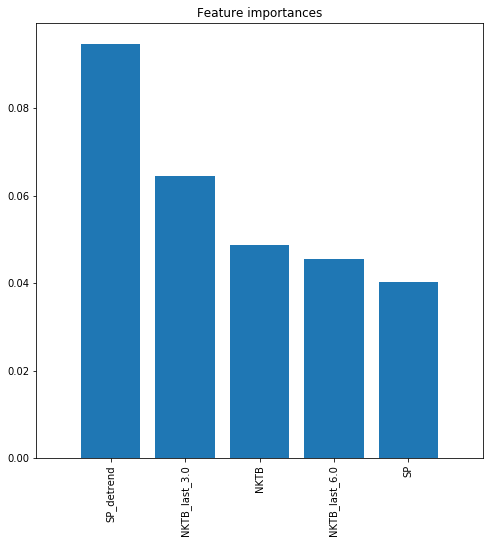

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
d_first = 5
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(features.columns)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [56]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7, stratify=target)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        #print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=5)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


 n_neighbors 
1
 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

       -9999       1.00      1.00      1.00     12169

   micro avg       1.00      1.00      1.00     12169
   macro avg       1.00      1.00      1.00     12169
weighted avg       1.00      1.00      1.00     12169

 n_neighbors 
2
 cross_val_predict 2 neighbors 
              precision    recall  f1-score   support

       -9999       1.00      1.00      1.00     12169

   micro avg       1.00      1.00      1.00     12169
   macro avg       1.00      1.00      1.00     12169
weighted avg       1.00      1.00      1.00     12169

 n_neighbors 
3
 cross_val_predict 3 neighbors 
              precision    recall  f1-score   support

       -9999       1.00      1.00      1.00     12169

   micro avg       1.00      1.00      1.00     12169
   macro avg       1.00      1.00      1.00     12169
weighted avg       1.00      1.00      1.00     12169

 n_neighbors 
4
 cross_val_predict 4 

In [72]:
def check_OneVsRestClassifier_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.9, stratify=labels)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    for i in range(1, 5):
        reg = RandomForestClassifier(random_state = i, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

        OVR = OneVsRestClassifier(reg,n_jobs=-1)
        OVR.fit(X_train, y_train)
    
        p(y_test, OVR.predict(X_test).round())
    return OVR

check_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 2.8196948682385576
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       210
           1       0.95      0.75      0.84        77
           3       0.97      0.49      0.65        76
           5       0.86      0.99      0.92      1083
           7       0.84      0.86      0.85       523
           8       0.77      0.70      0.73        99
          12       1.00      0.62      0.77        95

   micro avg       0.86      0.86      0.86      2163
   macro avg       0.90      0.71      0.78      2163
weighted avg       0.87      0.86      0.85      2163

RMSE ошибка равна 2.6879334257975036
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       210
           1       0.95      0.77      0.85        77
           3       0.97      0.47      0.64        76
           5       0.86      0.99      0.92      1083
           7       0.84      0.85      0.85       523
    

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=4, verbose=0, warm_start=False),
          n_jobs=-1)

In [68]:
def get_catBoost_GridSearchCV_prod(train, labels):
    from catboost import CatBoostClassifier, Pool
     
    model = CatBoostClassifier(iterations=108,
                               depth=6,
                               loss_function='MultiClass',
                           logging_level='Silent')
    model.fit(train, labels)
    #p_cross_val(model, train, labels)

    return model
    
catboost_GridSearchCV_model_best_prod = get_catBoost_GridSearchCV_prod(features, target_facies)

In [77]:


def get_features_filtering(wells):
    well_copy = wells.copy()
    del well_copy['LAYER']
    del well_copy['datasetName']
    well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if name_feature != 'wellName' and name_feature != 'Facies':
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()

def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class


for_ml_with_features_train_predict_ = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features_train_predict_.describe())

features_ = get_for_learn_featres(for_ml_with_features_train_predict_)
target_facies_ = get_for_learn_target_class(for_ml_with_features_train_predict_)
display(features_)

MD
BK
GR
LIT
NKTB
SP
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


MD            BK   Facies            GR           LIT  \
count  12169.000000  12169.000000  12169.0  12169.000000  12169.000000   
mean    2318.994461     33.511899  -9999.0     10.578728      2.077574   
std      295.858657    393.849799      0.0      9.497180      1.508217   
min     1670.000000      0.625000  -9999.0      1.400000      1.000000   
25%     2072.600000      5.270000  -9999.0      7.380000      1.000000   
50%     2376.800000      6.970000  -9999.0      8.819000      1.000000   
75%     2585.800000      9.800000  -9999.0     10.540000      4.000000   
max     3078.000000  19841.920000  -9999.0    122.272000      6.000000   

               NKTB            SP    SP_detrend   GR_last_3.0   SP_last_3.0  \
count  12169.000000  12169.000000  12169.000000  12169.000000  12169.000000   
mean       3.385778    100.541927      0.598454     10.415457    100.486525   
std        1.018692     29.911684     14.080240      9.080642     29.869643   
min        0.970000     45.710000    -58.978999      1.400000     45.710000   
25%        2.700000     81.313060     -6.456174      7.370000     81.083870   
50%        3.300000     99.034760      4.052678      8.790000     99.040000   
75%        3.890000    113.850000     11.484753     10.480000    113.789800   
max       14.500000    204.986800     25.101126    122.272000    204.986800   

       ...  BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  \
count  ...  12169.000000    12169.000000  12169.000000  12169.000000   
mean   ...     15.867709        3.406635      9.639770    100.907657   
std    ...     79.076518        1.015528      5.110099     32.859643   
min    ...      0.707000        0.970000      0.680000     45.710000   
25%    ...      5.242000        2.710000      7.350000     80.740000   
50%    ...      6.830000        3.320000      8.780000     99.310000   
75%    ...      9.350000        3.910615     10.440000    113.857200   
max    ...   2931.580000       14.500000     86.452000    578.255500   

       BK_last_15.0  NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count  12169.000000    12169.000000  12169.000000  12169.000000  12169.000000   
mean      31.255497        3.436892      9.569629     99.975387     12.271286   
std      443.859131        1.041030      5.424101     29.498630     59.671501   
min        0.707000        0.970000      2.560000     45.710000      0.707000   
25%        5.310000        2.750000      7.320000     80.844750      5.230000   
50%        7.110000        3.340000      8.700000     98.360000      6.774000   
75%       10.510000        3.929086     10.320000    112.350000      9.210000   
max    22739.520000       14.500000    100.450000    205.800300   2850.710000   

       NKTB_next_15.0  
count    12169.000000  
mean         3.413243  
std          1.007767  
min          0.970000  
25%          2.730000  
50%          3.330000  
75%          3.924000  
max         14.500000  

[8 rows x 48 columns]

BK      GR      NKTB        SP  SP_detrend  GR_last_3.0  \
5030    32.310  46.830  3.251999  124.8100    2.874596       11.610   
5031     9.130  43.030  3.328372  123.4100    1.469820       11.460   
5032     4.210  34.810  3.422103  122.0800    0.135044       11.200   
5033     2.190  24.770  3.581842  121.6700   -0.279732       11.380   
5034     2.480  17.870  3.736615  119.9200   -2.034509       12.050   
5035     4.980  12.970  3.908039  117.6000   -4.359285       12.880   
5036     8.390   9.970  4.029010  115.8700   -6.094061       14.640   
5037     8.660   9.120  4.070122  114.4000   -7.568837       16.860   
5038     2.730  10.320  4.061924  115.7900   -6.183614       17.110   
5039     2.580  12.770  3.995902  116.4500   -5.528390       15.290   
5040     4.230  14.350  4.020751  115.0100   -6.973166       13.680   
5041     4.810  14.220  4.179664  113.1100   -8.877942       13.100   
5042     5.330  13.560  4.219713  110.3800  -11.612719       12.050   
5043     6.940  13.200  4.259491  106.6300  -15.367495       10.520   
5248     6.220  15.400  3.604244  127.0000    4.023376       12.450   
5249     5.690  16.310  3.500345  125.3100    2.328600       11.380   
5250     5.090  16.490  3.472875  125.6100    2.623824       11.420   
5251     4.910  15.740  3.595296  123.9200    0.929048       12.040   
5252     5.230  14.110  3.805851  122.3200   -0.675729       12.560   
5253     4.310  12.410  3.950053  120.4200   -2.580505       12.660   
5254     4.310  11.730  3.966770  119.2200   -3.785281       12.980   
5255     5.100  11.700  3.983436  118.0500   -4.960057       13.550   
5256     4.900  12.130  4.020751  118.3200   -4.694834       13.350   
5257     4.470  13.320  4.012480  119.8400   -3.179610       12.940   
5258     4.660  14.880  3.886909  120.5700   -2.454386       13.200   
5259     4.840  15.950  3.719162  121.2000   -1.829162       13.250   
5260     4.900  15.730  3.639882  121.7300   -1.303939       13.520   
5261     4.250  14.420  3.827301  120.6600   -2.378715       14.390   
5262     4.130  13.510  3.975109  118.8500   -4.193491       15.090   
5263     4.510  12.450  4.106868  116.2600   -6.788267       15.410   
...        ...     ...       ...       ...         ...          ...   
124963   5.543  16.082  3.232670  197.5002    3.905703       14.132   
124964   5.842  15.142  3.121439  196.8684    3.264681       14.160   
124965   5.838  14.052  2.915124  198.2115    4.598559       14.198   
124966   4.915  14.357  3.390546  199.3437    5.721537       13.832   
124967   4.971  14.856  3.357655  199.0498    5.418415       14.121   
124968   4.548  14.673  3.211141  197.6740    4.033393       13.650   
124969   4.349  14.252  3.400114  198.3622    4.712371       12.953   
124970   4.646  13.906  3.315794  198.8283    5.169249       12.601   
124971   6.397  14.520  3.238650  198.4905    4.822226       13.286   
124972   6.788  15.348  2.793129  198.2546    4.577104       14.891   
124973   6.686  15.326  2.754258  198.2668    4.580082       16.728   
124974   6.552  15.105  2.760836  197.5490    3.853060       16.008   
124975   6.390  14.673  2.769209  199.2081    5.502938       12.892   
124976   4.446  13.453  3.059246  198.4363    4.721916       11.513   
124977   3.767  13.840  3.087950  198.7404    5.016794       11.632   
124978   3.474  14.132  3.188417  199.9906    6.257772       10.546   
124979   3.266  14.160  3.408486  198.9187    5.176650        8.294   
124980   2.586  14.198  3.226092  197.8059    4.054628        7.674   
124981   3.125  13.832  3.334930  199.0331    5.272606        9.135   
124982   3.467  14.121  3.333136  198.3852    4.615484       10.695   
124983   4.060  13.650  3.421045  199.0174    5.238462       11.400   
124984   4.438  12.953  3.087352  198.5766    4.788440       12.011   
124985   7.055  12.601  3.553205  199.4017    5.604318       13.858   
124986   6.743  13.286  3.308020  199.7689    5.962296       14.842   
124987   6.767  14.891  3.175261  19

In [78]:
name_model = 'predict_random_forest_BaseLine_0.75_0.70_f1_0.72'
for_ml_with_features_train_predict_[name_model] = prod_OneVsRest_RandomForest_model.predict(features_)
for_ml_with_features_train_predict_['predict_BaseLine_cat_boost_7008'] = catboost_GridSearchCV_model_best_prod.predict(features_)

for_ml_with_features_train_predict_.to_csv('DATATRAIN18+LAYER' + name_model, index=False)

In [80]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            name_feature != 'BK' and
             name_feature != 'GR' and
             name_feature != 'LIT' and
             name_feature != 'NKTB' and
            name_feature != 'SP' and
            name_feature != name_model and
            name_feature != 'predict_BaseLine_cat_boost_7008'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('DATATRAIN18+LAYER_' + name_model +'_smile.csv', index=False)
    
save(for_ml_with_features_train_predict_)

Facies
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


In [18]:

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names_:
        display(name)
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells


def get_correct_wells(wells):
    def is_md_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        copy_df_ = copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001]
        return copy_df_.empty and df_['MD'].count() > 10

    def print_md_not_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        display(copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001])

    wells_new = []
    for well in wells:
        if is_md_correct(well):
            wells_new.append(well)
        else:
            print(well['wellName'].iloc[0])
            #print_md_not_correct(well)
    return wells_new


def add_wells_features(wells, features_for_detrend):
    wells_new = []
    for well in wells:
        wells_new.append(detrend(well, features_for_detrend))
    return wells_new


def detrend(df, features_for_detrend):
    undefined_value = -9999

    def corrector_detrend(row, name_base, name_detrend):
        if row[name_base] < -999:
            return undefined_value
        if row[name_base] > 500:
            return undefined_value
        if row[name_detrend] > 999:
            return undefined_value
        if row[name_detrend] < -999:
            return undefined_value
        return row[name_detrend]

    import math
    def corrector_nulls(value):
        if math.isnan(value):
            return undefined_value
        if math.isinf(value):
            return undefined_value
        if value == 'NaN':
            return undefined_value
        return value

    def remove_trend(serials):
        from scipy import signal
        return signal.detrend(serials)

    copy_df = df.copy()

    for feature in features_for_detrend:
        prefix = '_det'
        copy_df[feature + prefix] = copy_df[feature] - copy_df[feature].shift(-1)
        copy_df[feature] = copy_df[feature].apply(corrector_nulls)
        copy_df[feature + prefix] = remove_trend(copy_df[feature])
        copy_df[feature + '_detrend'] = copy_df.apply(
            lambda row: corrector_detrend(row, feature, feature + prefix), axis=1)
        del copy_df[feature + prefix]
    return copy_df

def get_problem_wells(wells):
    def is_md_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        copy_df_ = copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001]
        return copy_df_.empty

    def print_md_not_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        display(copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001])

    wells_problem = []
    for well in wells:
        if is_md_correct(well) == False:
            if well['wellName'].iloc[0] not in ['spk1725', 'spk404', 'spk820PL']:
                print(well['wellName'].iloc[0])
                print_md_not_correct(well)
                wells_problem.append(well)
    return wells_problem

def get_for_learn_clean_df_prod(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    # feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["GR"] >= -999]
    feature = feature[feature["SP"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    return feature


name_dataset_for_predict = 'TRAIN18PRED.csv'
one = pd.read_csv(name_dataset_for_predict, sep=';')
two = pd.read_csv('S-POKUR_dop.csv', sep=';')
two['wellName'] = two['wellName'].apply(lambda x: x.replace('***', 'spk'))
del two['AGR']
del two['ASP']
concat_one_two = pd.concat([one, two])
wells_for_predict = get_for_learn_clean_df_prod(concat_one_two)
display(wells_for_predict.describe())
wells_samples_for_predict_df = get_well_dfs(wells_for_predict)
wells_problem = get_problem_wells(wells_samples_for_predict_df)
wells_correct = get_correct_wells(wells_samples_for_predict_df)
wells_add_detrends_for_predict_df = add_wells_features(wells_correct, ['SP'])
#wells_add_detrends_for_predict_df = add_wells_features(wells_correct, ['SP', 'GR', 'BK', 'NKTB'])
display(wells_problem.describe())

MD            BK             GR            LIT  \
count  554666.000000  4.319120e+05  554666.000000  385825.000000   
mean     2259.665319 -4.387582e+02       9.595629   -6265.503526   
std       381.570628  9.976990e+03       6.188189    4837.336245   
min       502.000000 -9.999000e+03       0.000000   -9999.000000   
25%      1992.800000  4.680000e+00       7.040000   -9999.000000   
50%      2265.600000  6.400000e+00       8.720000   -9999.000000   
75%      2534.000000  8.330000e+00      10.782000       1.000000   
max      3270.200000  6.402033e+06     164.851000       6.000000   

                NKTB             SP  
count  554666.000000  554666.000000  
mean     -325.266234      88.218068  
std      1783.875177      37.793637  
min     -9999.000000    -129.180000  
25%         2.840000      59.461515  
50%         3.560000      87.170000  
75%         4.185172     115.482600  
max        30.500000     232.902900

'spk1059L'

'spk1061'

'spk1062'

'spk1205L'

'spk1245PL'

'spk146R'

'spk1504'

'spk1506L'

'spk1508'

'spk1515'

'spk1517'

'spk1518L'

'spk1519L'

'spk1523'

'spk1524'

'spk1525'

'spk1528'

'spk1529'

'spk1530'

'spk1531'

'spk1537'

'spk1650PL'

'spk1652PL'

'spk1654PL'

'spk1656PL'

'spk1660PA'

'spk1662PL'

'spk1663'

'spk1664PL'

'spk1665PL'

'spk1700'

'spk1701'

'spk1702'

'spk1703'

'spk1704'

'spk1705'

'spk1706L'

'spk1707'

'spk1708'

'spk1709'

'spk1710'

'spk1718'

'spk1725'

'spk1740'

'spk1741'

'spk1742'

'spk1745L'

'spk1750'

'spk1753'

'spk1755'

'spk1760'

'spk1764'

'spk1765'

'spk1779'

'spk1785'

'spk1786'

'spk1791'

'spk1792'

'spk1793'

'spk1794'

'spk1796'

'spk1805'

'spk1821'

'spk1822PL'

'spk1826PL'

'spk214P'

'spk236'

'spk3203'

'spk3203PL'

'spk401'

'spk404'

'spk407R'

'spk408'

'spk421R'

'spk422R'

'spk425'

'spk437'

'spk467'

'spk490'

'spk564P'

'spk632'

'spk720PL'

'spk762PL'

'spk764PL'

'spk804'

'spk805'

'spk808'

'spk820PL'

'spk833R'

'spk870PL'

'spk872PL'

'spk902'

'spk904'

'spk908'

'spk914'

'spk924L'

'spk941'

'spk963L'

'spk1036'

'spk1150'

'spk1518'

'spk1743'

'spk1746'

'spk1747'

'spk1749PL'

'spk1750PL'

'spk1768'

'spk1779PL'

'spk1799PL'

spk1245PL


wellName      MD  BK     GR  LAYER  LIT   NKTB     SP  MD_difference
40471  spk1245PL  2553.0 NaN  6.782  -9999  NaN  3.742  0.429            3.0
40578  spk1245PL  2574.4 NaN  6.499  -9999  NaN  3.799  0.889            2.0

spk1660PA


wellName      MD    BK    GR  LAYER  LIT    NKTB    SP  MD_difference
226485  spk1660PA  1830.2  9.48  5.64  -9999  NaN -9999.0  0.25            1.6
226490  spk1660PA  1831.2  4.71  4.70  -9999  NaN -9999.0  0.65            0.6

spk214P


wellName      MD    BK     GR  LAYER  LIT     NKTB        SP  \
626382  spk214P  2552.4  5.35  14.31  Georg  1.0  3.64499  145.6656   

        MD_difference  
626382            2.6

spk401


wellName      MD    BK    GR  LAYER     LIT      NKTB        SP  \
647262   spk401  1649.8  7.25  6.25  -9999 -9999.0  3.162259  103.3027   

        MD_difference  
647262            6.6

spk407R


wellName      MD     BK     GR  LAYER     LIT      NKTB        SP  \
681312  spk407R  2388.8  4.385  9.505  -9999 -9999.0  4.612137  112.5925   

        MD_difference  
681312            1.8

spk564P


wellName      MD   BK     GR  LAYER     LIT   NKTB        SP  \
738882  spk564P  2517.6  4.2  11.89  -9999 -9999.0  2.835  105.6619   

        MD_difference  
738882            4.0

spk833R


wellName      MD       BK    GR  LAYER     LIT      NKTB        SP  \
822011  spk833R  2292.0  11.1895  8.11  -9999 -9999.0  3.467796  69.11457   

        MD_difference  
822011            1.0

spk1245PL
spk1660PA
spk1725
spk1740
spk214P
spk401
spk404
spk407R
spk564P
spk820PL
spk833R


AttributeError: 'list' object has no attribute 'describe'

In [19]:
wells_for_predict[wells_for_predict['wellName'] == 'spk1740']

wellName      MD    BK    GR  LAYER     LIT  NKTB     SP
423516  spk1740  1769.0  6.79  6.74  -9999 -9999.0  2.04  50.95

In [20]:
pd.concat(wells_problem)['wellName'].unique()

array(['spk1245PL', 'spk1660PA', 'spk214P', 'spk401', 'spk407R',
       'spk564P', 'spk833R'], dtype=object)

In [21]:
pd.concat(wells_problem)['wellName'].unique()

array(['spk1245PL', 'spk1660PA', 'spk214P', 'spk401', 'spk407R',
       'spk564P', 'spk833R'], dtype=object)

In [22]:
len(wells_samples_for_predict_df)

109

In [23]:
len(wells_add_detrends_for_predict_df)

98

In [83]:
wells_add_detrends_for_predict_df_ = wells_add_detrends_for_predict_df[wells_add_detrends_for_predict_df['wellName'] != 'spk1504']

TypeError: list indices must be integers or slices, not str

In [24]:
wells_add_detrends_for_predict_df[5]


wellName      MD     BK     GR  LAYER     LIT      NKTB      SP  \
54949  spk1504  1818.0   4.15   9.74  -9999 -9999.0  3.465461   82.48   
54950  spk1504  1818.2   4.23  10.12  -9999 -9999.0  3.460559   79.92   
54951  spk1504  1818.4   4.26   9.88  -9999 -9999.0  3.475252   79.14   
54952  spk1504  1818.6   4.42   9.33  -9999 -9999.0  3.557847   79.93   
54953  spk1504  1818.8   4.97   8.73  -9999 -9999.0  3.747987   78.41   
54954  spk1504  1819.0   7.03   8.21  -9999 -9999.0  3.799305   77.64   
54955  spk1504  1819.2   6.29   8.45  -9999 -9999.0  3.620272   77.41   
54956  spk1504  1819.4   5.41   9.28  -9999 -9999.0  3.440913   77.25   
54957  spk1504  1819.6   4.24   9.45  -9999 -9999.0  3.341692   78.32   
54958  spk1504  1819.8   4.19   9.19  -9999 -9999.0  3.250923   81.27   
54959  spk1504  1820.0   4.24   9.10  -9999 -9999.0  3.189592   80.95   
54960  spk1504  1820.2   4.06   8.89  -9999 -9999.0  3.199861   79.41   
54961  spk1504  1820.4   4.01   8.86  -9999 -9999.0  3.245838   79.27   
54962  spk1504  1820.6   4.04   9.04  -9999 -9999.0  3.281340   79.47   
54963  spk1504  1820.8   4.03   9.13  -9999 -9999.0  3.301528   78.72   
54964  spk1504  1821.0   4.35   9.04  -9999 -9999.0  3.301528   78.21   
54965  spk1504  1821.2   4.32   9.11  -9999 -9999.0  3.311595   77.88   
54966  spk1504  1821.4   4.27   8.91  -9999 -9999.0  3.331677   77.94   
54967  spk1504  1821.6   4.33   8.42  -9999 -9999.0  3.311595   78.77   
54968  spk1504  1821.8   4.38   8.65  -9999 -9999.0  3.261080   80.13   
54969  spk1504  1822.0   4.25   8.48  -9999 -9999.0  3.240748   80.84   
54970  spk1504  1822.2   4.19   8.45  -9999 -9999.0  3.256004   80.42   
54971  spk1504  1822.4   4.25   8.99  -9999 -9999.0  3.286394   78.44   
54972  spk1504  1822.6   4.21   8.93  -9999 -9999.0  3.256004   77.88   
54973  spk1504  1822.8   4.17   8.63  -9999 -9999.0  3.189592   77.90   
54974  spk1504  1823.0   4.19   8.83  -9999 -9999.0  3.153501   78.08   
54975  spk1504  1823.2   4.20   9.08  -9999 -9999.0  3.204988   78.62   
54976  spk1504  1823.4   4.19   9.16  -9999 -9999.0  3.281340   79.32   
54977  spk1504  1823.6   4.23   9.42  -9999 -9999.0  3.311595   80.06   
54978  spk1504  1823.8   4.21   9.38  -9999 -9999.0  3.194729   79.15   
...        ...     ...    ...    ...    ...     ...       ...     ...   
60034  spk1504  2835.0  23.93   7.29  UV1_3 -9999.0  5.192657  129.01   
60035  spk1504  2835.2   8.82   7.87  UV1_3 -9999.0  4.984461  130.26   
60036  spk1504  2835.4   6.93  10.28  UV1_3 -9999.0  4.531209  131.15   
60037  spk1504  2835.6   6.82  12.28  UV1_3 -9999.0  3.996217  132.52   
60038  spk1504  2835.8   6.74  12.86  UV1_3 -9999.0  3.817868  130.94   
60039  spk1504  2836.0   6.75  12.52  UV1_3 -9999.0  3.868649  129.16   
60040  spk1504  2836.2   6.98  11.70  UV1_3 -9999.0  4.005239  128.60   
60041  spk1504  2836.4   7.62  11.80  UV1_3 -9999.0  4.117047  128.33   
60042  spk1504  2836.6   8.72  11.78  UV1_3 -9999.0  4.152459  128.38   
60043  spk1504  2836.8   8.79  10.58  UV1_3 -9999.0  4.192089  129.26   
60044  spk1504  2837.0   8.71  10.74  UV1_3 -9999.0  4.235872  130.31   
60045  spk1504  2837.2   6.99  11.95  UV1_3 -9999.0  4.196479  130.99   
60046  spk1504  2837.4   6.79  12.44  UV1_3 -9999.0  4.018750  130.93   
60047  spk1504  2837.6   6.84  13.45  UV1_3 -9999.0  3.882432  129.69   
60048  spk1504  2837.8   7.69  13.40  UV1_3 -9999.0  3.914483  128.60   
60049  spk1504  2838.0   8.35  12.36  UV1_3 -9999.0  3.973610  127.98   
60050  spk1504  2838.2   7.71  12.01  UV1_3 -9999.0  3.973610  127.67   
60051  spk1504  2838.4   6.99  12.31  UV1_3 -9999.0  3.923612  128.28   
60052  spk1504  2838.6   6.92  12.70  UV1_3 -9999.0  3.946384  129.57   
60053  spk1504  2838.8   7.41  12.27  UV1_3 -9999.0  3.969080  132.35   
60054  spk1504  2839.0   6.85  11.90  UV1_3 -9999.0  3.969080  132.41   
60055  spk1504  2839.2   6.75  12.79  UV1_3 -9999.0  3.969080  131.04   
60056  spk1504  2839.4   8.11  13.05  UV1_3 -9999.0  4.014250  1

In [25]:

def standarize_feature_prod(train_df, cols):       
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    for col in cols:
        train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1,1).astype(np.float32))

    return None

def get_well_with_features_df_rebost_prod(wells):
    wells_return = []
    wells_nulls = []
    for well in wells:
        well_copy = well.copy().dropna()
        if not well_copy.empty:
            standarize_feature_prod(well_copy, [i for i in well_copy.columns if i!= 'wellName' 
                                       and i!='datasetName'  
                                       and i!='MD'
                                       and i!='LAYER'
                                       and i!='LIT'
                                       and i!='Facies'])
            wells_return.append(well_copy)
    print(len(wells_nulls))
    return wells_return


well_with_features_for_predict = get_well_with_features_df(wells_add_detrends_for_predict_df, ['SP'], [0.1])
#well_with_features_for_predict = get_well_with_features_df_rebost_prod(well_with_features_for_predict)

for_ml_preprocessing_for_predict = pd.concat(well_with_features_for_predict)


def get_md_for_predict(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
                name_feature != 'LIT' and
           name_feature != 'datasetName'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature

for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_for_predict)
for_predict_df = get_features_for_predict(for_predict_df_prod)


0
MD
BK
GR
NKTB
SP
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


In [27]:
for_predict_df_prod

wellName      MD        BK       GR  LAYER     LIT      NKTB       SP  \
75      spk1059L  1780.0    2.8600   9.3500  -9999 -9999.0  3.245650   70.680   
76      spk1059L  1780.2    3.4000   9.9400  -9999 -9999.0  3.147607   71.200   
77      spk1059L  1780.4    3.7400  10.2500  -9999 -9999.0  3.120495   70.910   
78      spk1059L  1780.6    3.9100  10.8900  -9999 -9999.0  3.170075   72.310   
79      spk1059L  1780.8    3.8500  11.2400  -9999 -9999.0  3.183503   72.840   
80      spk1059L  1781.0    3.6600  10.9200  -9999 -9999.0  3.125026   73.710   
81      spk1059L  1781.2    3.4300  10.8600  -9999 -9999.0  3.074939   74.250   
82      spk1059L  1781.4    3.6300  10.7200  -9999 -9999.0  3.024276   75.270   
83      spk1059L  1781.6    4.0400  10.4700  -9999 -9999.0  3.028906   76.090   
84      spk1059L  1781.8    3.8000  10.4200  -9999 -9999.0  3.028906   76.200   
85      spk1059L  1782.0    3.8800  10.5300  -9999 -9999.0  3.047378   75.990   
86      spk1059L  1782.2    3.7800  10.5400  -9999 -9999.0  3.088655   75.040   
87      spk1059L  1782.4    4.0300  10.4000  -9999 -9999.0  3.115961   74.880   
88      spk1059L  1782.6    3.4600  10.3000  -9999 -9999.0  3.051984   72.700   
89      spk1059L  1782.8    3.1700  10.3600  -9999 -9999.0  3.074939   71.910   
90      spk1059L  1783.0    3.3700  10.4800  -9999 -9999.0  3.125026   70.530   
91      spk1059L  1783.2    3.6900  10.4600  -9999 -9999.0  3.115961   71.390   
92      spk1059L  1783.4    3.7600  10.7000  -9999 -9999.0  3.079516   71.280   
93      spk1059L  1783.6    3.6900  11.0200  -9999 -9999.0  3.102329   72.990   
94      spk1059L  1783.8    3.6900  10.8300  -9999 -9999.0  3.192433   72.180   
95      spk1059L  1784.0    3.7700  10.5000  -9999 -9999.0  3.263253   73.270   
96      spk1059L  1784.2    3.5800  10.5600  -9999 -9999.0  3.250057   74.730   
97      spk1059L  1784.4    3.6500  10.7900  -9999 -9999.0  3.196891   76.740   
98      spk1059L  1784.6    3.5400  10.9700  -9999 -9999.0  3.102329   76.370   
99      spk1059L  1784.8    3.5100  11.0100  -9999 -9999.0  2.991724   76.550   
100     spk1059L  1785.0    3.5300  10.7300  -9999 -9999.0  2.973011   75.580   
101     spk1059L  1785.2    3.6000  10.4600  -9999 -9999.0  3.019640   75.400   
102     spk1059L  1785.4    3.4400  10.8000  -9999 -9999.0  3.028906   73.590   
103     spk1059L  1785.6    3.8300  11.2200  -9999 -9999.0  3.047378   72.400   
104     spk1059L  1785.8    3.8600  11.2400  -9999 -9999.0  3.143099   71.640   
...          ...     ...       ...      ...    ...     ...       ...      ...   
36185  spk1749PL  2669.2    9.4886  10.7150  UV1_2     1.0  3.698050  147.049   
36186  spk1749PL  2669.4   19.8548   7.4535  UV1_3     5.0  4.693050  147.480   
36187  spk1749PL  2669.6   63.3306   5.2811  UV1_3     5.0  6.247700  147.600   
36188  spk1749PL  2669.8   93.1545   4.6549  UV1_3     5.0  7.528650  144.746   
36189  spk1749PL  2670.0   97.1937   4.5851  UV1_3     5.0  7.581450  142.625   
36190  spk1749PL  2670.2  101.7320   4.6189  UV1_3     5.0  7.339300  142.216   
36191  spk1749PL  2670.4   69.0369   5.0866  UV1_3     5.0  7.041650  141.511   
36192  spk1749PL  2670.6   40.9148   6.6546  UV1_3     5.0  6.485500  144.949   
36193  spk1749PL  2670.8   22.2451   8.8121  UV1_3     5.0  5.681350  146.952   
36194  spk1749PL  2671.0   11.5557  10.1369  UV1_3     2.0  4.748250  147.807   
36195  spk1749PL  2671.2    8.5914   9.8980  UV1_3     2.0  4.311900  145.478   
36196  spk1749PL  2671.4    7.2542   9.8386  UV1_3     2.0  4.247700  141.179   
36197  spk1749PL  2671.6    6.9922  10.5783  UV1_3     1.0  4.128400  140.725   
36198  spk1749PL  2671.8    7.5356  10.6893  UV1_3     1.0  3.933400  141.131   
36199  spk1749PL  2672.0    7.3204  10.5142  UV1_3     1.0  4.016750  142.152   
36200  spk1749PL  2672.2    7.7415  10.4329  UV1_3     1.0  4.327500  142.394   
36201  spk1749PL  2672.4    8.2929   9.6509  UV1_3     2.0  4.624650  142.877   
36202  spk1749PL  2672.6    8.5559   9.

In [28]:
for_predict_df_prod.describe()

MD            BK             GR            LIT  \
count  282864.000000  2.828640e+05  282864.000000  282864.000000   
mean     2240.196685  3.719483e+01       9.849269   -5945.285119   
std       305.378146  1.203867e+04       6.601252    4910.042764   
min      1639.600000  0.000000e+00       0.193000   -9999.000000   
25%      1990.000000  4.919875e+00       7.106000   -9999.000000   
50%      2236.400000  6.550000e+00       8.890000   -9999.000000   
75%      2480.000000  8.480000e+00      11.080000       1.000000   
max      3154.600000  6.402033e+06     164.851000       6.000000   

                NKTB             SP     SP_detrend    GR_last_3.0  \
count  282864.000000  282864.000000  282864.000000  282864.000000   
mean        3.849918      95.483585       0.092961       9.856235   
std         1.347088      37.856695      21.423157       6.607951   
min         0.570000      -4.600273     -95.641543       0.193000   
25%         3.147337      69.668647      -8.034305       7.110000   
50%         3.680542      96.212230       4.973183       8.893500   
75%         4.250000     122.234925      14.253505      11.090000   
max        30.500000     232.902900      64.158157     164.851000   

         SP_last_3.0   BK_last_3.0  ...  BK_next_12.0  NKTB_next_12.0  \
count  282864.000000  2.828640e+05  ...  2.828640e+05   282864.000000   
mean       95.555908  3.725774e+01  ...  3.717213e+01        3.836400   
std        37.836974  1.203867e+04  ...  1.203869e+04        1.343599   
min        -4.600273  0.000000e+00  ...  0.000000e+00        0.517801   
25%        69.740000  4.920000e+00  ...  4.900000e+00        3.131454   
50%        96.330000  6.560000e+00  ...  6.510000e+00        3.670000   
75%       122.270000  8.500000e+00  ...  8.400000e+00        4.239258   
max       232.902900  6.402033e+06  ...  6.402033e+06       30.500000   

        GR_last_15.0   SP_last_15.0  BK_last_15.0  NKTB_last_15.0  \
count  282864.000000  282864.000000  2.828640e+05   282864.000000   
mean        9.878004      95.789035  3.752214e+01        3.866598   
std         6.624732      37.859750  1.203873e+04        1.353353   
min         0.000000      -4.600273  0.000000e+00        0.570000   
25%         7.120000      69.950000  4.950000e+00        3.166785   
50%         8.910000      96.750175  6.600000e+00        3.695828   
75%        11.140000     122.452250  8.580000e+00        4.264000   
max       164.851000     232.902900  6.402033e+06       30.500000   

        GR_next_15.0   SP_next_15.0  BK_next_15.0  NKTB_next_15.0  
count  282864.000000  282864.000000  2.828640e+05   282864.000000  
mean        9.823974      95.074445  3.715815e+01        3.833563  
std         6.603605      37.959332  1.203869e+04        1.343684  
min         0.193000      -4.600273  0.000000e+00        0.517801  
25%         7.090000      69.160000  4.900000e+00        3.130000  
50%         8.860000      95.679070  6.500000e+00        3.667324  
75%        11.030000     121.990000  8.390000e+00        4.233000  
max       164.851000     232.902900  6.402033e+06       30.500000  

[8 rows x 47 columns]

In [29]:
name_model = 'predict_random_forest_BaseLine_0.75_0.70_f1_0.72'
for_predict_df_prod[name_model] = prod_OneVsRest_RandomForest_model.predict(for_predict_df)
for_predict_df_prod['predict_BaseLine_cat_boost_7008'] = catboost_GridSearchCV_model_best_prod.predict(for_predict_df)

for_predict_df_prod.to_csv('TRAIN18PRED_98_wells_' + name_model, index=False)

In [30]:
#for_predict_df_prod['predict_catboost_f1_0_77'] = for_predict_df_prod['predict_catboost_f1_0_']

In [31]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            name_feature != 'BK' and
             name_feature != 'GR' and
             name_feature != 'LIT' and
             name_feature != 'NKTB' and
            name_feature != 'SP' and
            name_feature != name_model and
            name_feature != 'predict_BaseLine_cat_boost_7008'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('TRAIN18PRED_98_wells_' + name_model +'_smile.csv', index=False)
    
save(for_predict_df_prod)


SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


In [32]:
for_predict_df_prod.describe()

MD            BK             GR            LIT  \
count  282864.000000  2.828640e+05  282864.000000  282864.000000   
mean     2240.196685  3.719483e+01       9.849269   -5945.285119   
std       305.378146  1.203867e+04       6.601252    4910.042764   
min      1639.600000  0.000000e+00       0.193000   -9999.000000   
25%      1990.000000  4.919875e+00       7.106000   -9999.000000   
50%      2236.400000  6.550000e+00       8.890000   -9999.000000   
75%      2480.000000  8.480000e+00      11.080000       1.000000   
max      3154.600000  6.402033e+06     164.851000       6.000000   

                NKTB             SP     SP_detrend    GR_last_3.0  \
count  282864.000000  282864.000000  282864.000000  282864.000000   
mean        3.849918      95.483585       0.092961       9.856235   
std         1.347088      37.856695      21.423157       6.607951   
min         0.570000      -4.600273     -95.641543       0.193000   
25%         3.147337      69.668647      -8.034305       7.110000   
50%         3.680542      96.212230       4.973183       8.893500   
75%         4.250000     122.234925      14.253505      11.090000   
max        30.500000     232.902900      64.158157     164.851000   

         SP_last_3.0   BK_last_3.0  ...   GR_last_15.0   SP_last_15.0  \
count  282864.000000  2.828640e+05  ...  282864.000000  282864.000000   
mean       95.555908  3.725774e+01  ...       9.878004      95.789035   
std        37.836974  1.203867e+04  ...       6.624732      37.859750   
min        -4.600273  0.000000e+00  ...       0.000000      -4.600273   
25%        69.740000  4.920000e+00  ...       7.120000      69.950000   
50%        96.330000  6.560000e+00  ...       8.910000      96.750175   
75%       122.270000  8.500000e+00  ...      11.140000     122.452250   
max       232.902900  6.402033e+06  ...     164.851000     232.902900   

       BK_last_15.0  NKTB_last_15.0   GR_next_15.0   SP_next_15.0  \
count  2.828640e+05   282864.000000  282864.000000  282864.000000   
mean   3.752214e+01        3.866598       9.823974      95.074445   
std    1.203873e+04        1.353353       6.603605      37.959332   
min    0.000000e+00        0.570000       0.193000      -4.600273   
25%    4.950000e+00        3.166785       7.090000      69.160000   
50%    6.600000e+00        3.695828       8.860000      95.679070   
75%    8.580000e+00        4.264000      11.030000     121.990000   
max    6.402033e+06       30.500000     164.851000     232.902900   

       BK_next_15.0  NKTB_next_15.0  \
count  2.828640e+05   282864.000000   
mean   3.715815e+01        3.833563   
std    1.203869e+04        1.343684   
min    0.000000e+00        0.517801   
25%    4.900000e+00        3.130000   
50%    6.500000e+00        3.667324   
75%    8.390000e+00        4.233000   
max    6.402033e+06       30.500000   

       predict_random_forest_BaseLine_0.75_0.70_f1_0.72  \
count                                     282864.000000   
mean                                           4.485311   
std                                            1.898006   
min                                            0.000000   
25%                                            5.000000   
50%                                            5.000000   
75%                                            5.000000   
max                                           12.000000   

       predict_BaseLine_cat_boost_7008  
count                    282864.000000  
mean                          4.471453  
std                           1.937243  
min                           0.000000  
25%                           5.000000  
50%                           5.000000  
75%                           5.000000  
max                          12.000000  

[8 rows x 49 columns]

In [33]:
for_predict_df_prod.describe()

MD            BK             GR            LIT  \
count  282864.000000  2.828640e+05  282864.000000  282864.000000   
mean     2240.196685  3.719483e+01       9.849269   -5945.285119   
std       305.378146  1.203867e+04       6.601252    4910.042764   
min      1639.600000  0.000000e+00       0.193000   -9999.000000   
25%      1990.000000  4.919875e+00       7.106000   -9999.000000   
50%      2236.400000  6.550000e+00       8.890000   -9999.000000   
75%      2480.000000  8.480000e+00      11.080000       1.000000   
max      3154.600000  6.402033e+06     164.851000       6.000000   

                NKTB             SP     SP_detrend    GR_last_3.0  \
count  282864.000000  282864.000000  282864.000000  282864.000000   
mean        3.849918      95.483585       0.092961       9.856235   
std         1.347088      37.856695      21.423157       6.607951   
min         0.570000      -4.600273     -95.641543       0.193000   
25%         3.147337      69.668647      -8.034305       7.110000   
50%         3.680542      96.212230       4.973183       8.893500   
75%         4.250000     122.234925      14.253505      11.090000   
max        30.500000     232.902900      64.158157     164.851000   

         SP_last_3.0   BK_last_3.0  ...   GR_last_15.0   SP_last_15.0  \
count  282864.000000  2.828640e+05  ...  282864.000000  282864.000000   
mean       95.555908  3.725774e+01  ...       9.878004      95.789035   
std        37.836974  1.203867e+04  ...       6.624732      37.859750   
min        -4.600273  0.000000e+00  ...       0.000000      -4.600273   
25%        69.740000  4.920000e+00  ...       7.120000      69.950000   
50%        96.330000  6.560000e+00  ...       8.910000      96.750175   
75%       122.270000  8.500000e+00  ...      11.140000     122.452250   
max       232.902900  6.402033e+06  ...     164.851000     232.902900   

       BK_last_15.0  NKTB_last_15.0   GR_next_15.0   SP_next_15.0  \
count  2.828640e+05   282864.000000  282864.000000  282864.000000   
mean   3.752214e+01        3.866598       9.823974      95.074445   
std    1.203873e+04        1.353353       6.603605      37.959332   
min    0.000000e+00        0.570000       0.193000      -4.600273   
25%    4.950000e+00        3.166785       7.090000      69.160000   
50%    6.600000e+00        3.695828       8.860000      95.679070   
75%    8.580000e+00        4.264000      11.030000     121.990000   
max    6.402033e+06       30.500000     164.851000     232.902900   

       BK_next_15.0  NKTB_next_15.0  \
count  2.828640e+05   282864.000000   
mean   3.715815e+01        3.833563   
std    1.203869e+04        1.343684   
min    0.000000e+00        0.517801   
25%    4.900000e+00        3.130000   
50%    6.500000e+00        3.667324   
75%    8.390000e+00        4.233000   
max    6.402033e+06       30.500000   

       predict_random_forest_BaseLine_0.75_0.70_f1_0.72  \
count                                     282864.000000   
mean                                           4.485311   
std                                            1.898006   
min                                            0.000000   
25%                                            5.000000   
50%                                            5.000000   
75%                                            5.000000   
max                                           12.000000   

       predict_BaseLine_cat_boost_7008  
count                    282864.000000  
mean                          4.471453  
std                           1.937243  
min                           0.000000  
25%                           5.000000  
50%                           5.000000  
75%                           5.000000  
max                          12.000000  

[8 rows x 49 columns]

In [34]:
for_predict_df_prod[for_predict_df_prod[name_model] == 7].describe()

MD            BK            GR           LIT          NKTB  \
count  28030.000000  28030.000000  28030.000000  28030.000000  28030.000000   
mean    2360.918081     17.929422      8.648995  -3543.314235      5.429124   
std      277.015769    383.100399      3.701927   4784.718055      2.086826   
min     1645.200000      0.480000      2.127000  -9999.000000      1.160000   
25%     2154.200000      6.700000      6.820000  -9999.000000      4.262097   
50%     2394.200000      8.340000      8.280000      1.000000      4.870000   
75%     2579.400000     10.900000     10.140000      4.000000      6.109838   
max     3108.400000  59441.550000    110.580000      6.000000     30.500000   

                 SP    SP_detrend   GR_last_3.0   SP_last_3.0   BK_last_3.0  \
count  28030.000000  28030.000000  28030.000000  28030.000000  28030.000000   
mean      93.190394    -15.938763      8.959764     98.419480     17.228305   
std       44.135331     23.781793      3.334299     43.856588    386.233162   
min       -4.600273    -86.053593      2.127000     -4.600273      0.710000   
25%       58.311250    -34.622044      6.970000     65.927660      6.346400   
50%       98.772880    -14.096313      8.689900    102.448900      7.950000   
75%      127.825250      2.481692     10.820000    130.748500     10.247500   
max      209.110600     49.996501     94.360000    231.458900  59441.550000   

       ...  GR_last_15.0  SP_last_15.0  BK_last_15.0  NKTB_last_15.0  \
count  ...  28030.000000  28030.000000  28030.000000    28030.000000   
mean   ...     10.025667    109.633876     10.451021        5.034449   
std    ...      3.072024     40.027421    109.343384        1.820876   
min    ...      1.700000     -0.782516      1.110000        0.680000   
25%    ...      7.820000     88.112000      5.710000        3.972610   
50%    ...      9.990000    109.190000      7.100000        4.583250   
75%    ...     12.120000    136.708925      8.900000        5.690000   
max    ...     69.319000    232.902900  13182.920000       25.292000   

       GR_next_15.0  SP_next_15.0  BK_next_15.0  NKTB_next_15.0  \
count  28030.000000  28030.000000  28030.000000    28030.000000   
mean      12.565583    109.999964     32.609990        4.858792   
std       11.702612     38.171155    404.076015        1.866245   
min        0.193000      1.564484      0.785000        0.780000   
25%        8.200000     89.682500      5.370000        3.786223   
50%       10.253650    108.920000      6.860000        4.448000   
75%       12.410000    134.250000      8.900000        5.510000   
max      164.851000    231.950300  59441.550000       28.470000   

       predict_random_forest_BaseLine_0.75_0.70_f1_0.72  \
count                                           28030.0   
mean                                                7.0   
std                                                 0.0   
min                                                 7.0   
25%                                                 7.0   
50%                                                 7.0   
75%                                                 7.0   
max                                                 7.0   

       predict_BaseLine_cat_boost_7008  
count                     28030.000000  
mean                          5.910453  
std                           2.245511  
min                           0.000000  
25%                           5.000000  
50%                           7.000000  
75%                           7.000000  
max                          12.000000  

[8 rows x 49 columns]

In [35]:
for_predict_df_prod[for_predict_df_prod['predict_BaseLine_cat_boost_7008'] == 7].describe()

MD            BK            GR           LIT          NKTB  \
count  30489.000000  30489.000000  30489.000000  30489.000000  30489.000000   
mean    2402.937249     19.360832      9.323979  -2867.059464      5.654070   
std      264.565914    452.780224      4.196092   4524.071750      1.991790   
min     1645.000000      0.480000      2.153000  -9999.000000      1.885854   
25%     2210.600000      6.600000      7.140000  -9999.000000      4.456200   
50%     2441.800000      8.160000      8.669000      1.000000      5.050000   
75%     2603.400000     10.790000     11.250000      4.000000      6.270000   
max     3107.800000  59441.550000    110.580000      6.000000     30.500000   

                 SP    SP_detrend   GR_last_3.0   SP_last_3.0   BK_last_3.0  \
count  30489.000000  30489.000000  30489.000000  30489.000000  30489.000000   
mean      96.525334    -13.863009      9.615053    101.452200     17.678901   
std       37.345776     23.546389      3.915125     37.944681    448.595477   
min       -1.303268    -92.945851      2.127000      0.636000      0.000000   
25%       70.720000    -31.336719      7.360000     78.290000      6.320000   
50%      103.930000    -11.401776      9.170000    108.181900      7.820000   
75%      122.870000      3.952396     11.830000    125.325700     10.140000   
max      196.303200     49.996501    110.580000    231.458900  59441.550000   

       ...  GR_last_15.0  SP_last_15.0  BK_last_15.0  NKTB_last_15.0  \
count  ...  30489.000000  30489.000000  30489.000000    30489.000000   
mean   ...     10.453719    110.573057     10.908871        5.304678   
std    ...      3.166053     35.153420    121.038246        1.768733   
min    ...      0.000000      0.000000      0.000000        1.323000   
25%    ...      8.220500     95.240000      5.880000        4.198129   
50%    ...     10.470000    114.510000      7.210000        4.800000   
75%    ...     12.660000    129.830700      8.930000        5.930000   
max    ...     75.857000    232.902900  13182.920000       27.090000   

       GR_next_15.0  SP_next_15.0  BK_next_15.0  NKTB_next_15.0  \
count  30489.000000  30489.000000  30489.000000    30489.000000   
mean      12.830771    109.792847     31.950998        5.210695   
std       11.449016     35.130546    386.850409        1.925425   
min        0.193000      2.481000      0.000000        1.300000   
25%        8.430000     94.558000      5.570000        4.060000   
50%       10.611400    112.883000      7.072200        4.724800   
75%       12.830000    128.370000      9.320000        5.860000   
max      110.580000    231.950300  59441.550000       28.470000   

       predict_random_forest_BaseLine_0.75_0.70_f1_0.72  \
count                                      30489.000000   
mean                                           6.002165   
std                                            1.957112   
min                                            0.000000   
25%                                            5.000000   
50%                                            7.000000   
75%                                            7.000000   
max                                           12.000000   

       predict_BaseLine_cat_boost_7008  
count                          30489.0  
mean                               7.0  
std                                0.0  
min                                7.0  
25%                                7.0  
50%                                7.0  
75%                                7.0  
max                                7.0  

[8 rows x 49 columns]

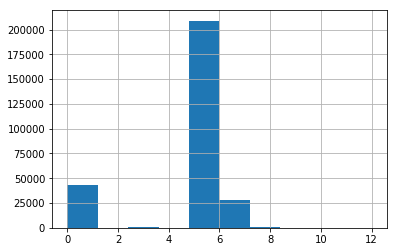

In [36]:
for_predict_df_prod[name_model].hist()

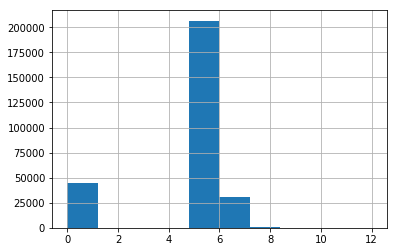

In [38]:
for_predict_df_prod['predict_BaseLine_cat_boost_7008'].hist()

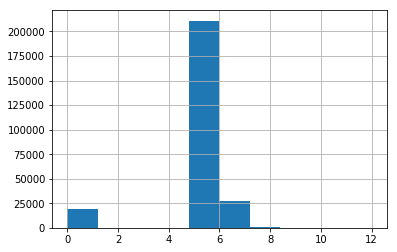

In [58]:
for_predict_df_prod['predict_random_forest_f1_0_80'].hist()

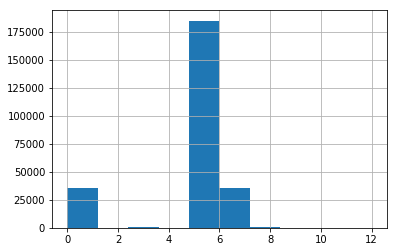

In [59]:
for_predict_df_prod['predict_catboost_f1_0_77'].hist()

In [143]:
rmse = mean_squared_error(for_predict_df_prod['predict_random_forest_f1_0_84'], for_predict_df_prod['predict_catboost_f1_0_77'])
print('rmse ' + str(rmse))

KeyError: 'predict_catboost_f1_0_77'

In [134]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def get_well_with_distance_features__(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'SP')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'SP')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy


def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
            if part[name].max() == part[name].min():
                part['std_' + new_feature_prefix + name] = 0
            else:
                part['std_' + new_feature_prefix + name] = part[name].std()
            part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()
        well_copy = get_well_with_distance_features__(well_copy)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


well_with_features = get_well_with_features_df(wells_add_detrends_df, ['SP'], [0.1])
for_ml_preprocessing = pd.concat(well_with_features)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0


In [137]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
def standarize_feature(train_df, cols, test_df=0):
    def save_simple_model(model, name):
        import pickle
        from sklearn.externals import joblib
        with open(name, 'wb') as f:
             pickle.dump(model, f)
            
    def load_simple_model(name):
        from sklearn.externals import joblib
        test_load_model = joblib.load(name)
        return test_load_model
    
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    for col in cols:
        train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1,1).astype(np.float32))
        #if type(test_df)!=int:
            #test_df[col] = scaler.transform(test_df[col].values.reshape(-1,1).astype(np.float32))
    save_simple_model(scaler, 'RobustScaler')
    return None

def get_well_with_features_df_rebost(wells):
    wells_return = []
    wells_nulls = []
    for well in wells:
        well_copy = well.copy().dropna()
        if not well_copy.empty:
            standarize_feature(well_copy, [i for i in well_copy.columns if i!= 'wellName' 
                                       and i!='datasetName'  
                                       and i!='MD'
                                       and i!='LAYER'
                                       and i!='LIT'
                                       and i!='Facies'])
            wells_return.append(well_copy)
    print(len(wells_nulls))
    return wells_return

well_with_features_ = get_well_with_features_df_rebost(well_with_features)
for_ml_preprocessing = pd.concat(well_with_features_)



def get_features_filtering(wells):
    well_copy = wells.copy()
    del well_copy['LAYER']
    del well_copy['datasetName']
    #del well_copy['BK']
    #del well_copy['NKTB']
    well_copy = well_copy[well_copy['Facies'] > -1]
    for name_feature in well_copy.columns:
        if name_feature != 'wellName' and name_feature != 'Facies':
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()

def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class


for_ml_with_features = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())

features = get_for_learn_featres(for_ml_with_features)
target_facies = get_for_learn_target_class(for_ml_with_features)
display(features)

0
MD
BK
GR
LIT
NKTB
SP
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


MD            BK       Facies           GR          LIT  \
count  2407.000000   2407.000000  2407.000000  2407.000000  2407.000000   
mean   2616.836311   2109.883301     5.227669    -0.168792     2.272538   
std     135.646068   4082.559326     2.568694     0.737557     1.530137   
min    2507.600000     -0.934485     0.000000    -1.926641     1.000000   
25%    2551.000000      0.208689     5.000000    -0.763035     1.000000   
50%    2573.600000      0.999920     5.000000    -0.227842     1.000000   
75%    2603.000000      6.165843     7.000000     0.386310     4.000000   
max    3060.400000  10177.602539    12.000000     1.942326     5.000000   

              NKTB           SP   SP_detrend  GR_last_3.0  SP_last_3.0  ...  \
count  2407.000000  2407.000000  2407.000000  2407.000000  2407.000000  ...   
mean      0.966037    -0.131862    -0.542684    -0.134195    -0.105791  ...   
std       1.026344     0.440139     0.536828     0.747278     0.429767  ...   
min      -1.405964    -1.707471    -2.852888    -1.924783    -1.734725  ...   
25%       0.274376    -0.380624    -0.806790    -0.748140    -0.335583  ...   
50%       0.795872    -0.048851    -0.393469    -0.137404    -0.027430  ...   
75%       1.438776     0.174170    -0.173571     0.437883     0.183037  ...   
max       6.766817     0.861024     0.215628     1.935910     0.877302  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2407.000000     2407.000000   2407.000000   2407.000000   2407.000000   
mean    2148.726562        0.534740     -0.080289     -0.036383   2109.113037   
std     4099.158203        1.264567      0.655496      0.382677   4082.252686   
min     -759.496277       -2.722891     -1.746695     -1.552517     -0.775904   
25%        0.545454       -0.265153     -0.550000     -0.257968      0.065217   
50%        3.170809        0.484536     -0.065952      0.011903      0.657143   
75%      134.329895        1.157572      0.439681      0.217194      2.762593   
max    11485.592773        6.725333      1.917916      0.917966  10123.256836   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2407.000000   2407.000000   2407.000000   2407.000000   
mean         0.772520      4.873693     -0.016010   2162.942139   
std          0.942468      7.623682      0.477888   4110.545898   
min         -1.165177     -1.740476     -1.590093   -759.494446   
25%          0.164835     -0.341400     -0.257821      0.870296   
50%          0.635317      0.765326      0.086354      6.525582   
75%          1.186992     10.316683      0.245032    188.308334   
max          5.056912     31.917309      1.302923  11485.592773   

       NKTB_next_15.0  
count     2407.000000  
mean         0.368594  
std          1.341069  
min         -2.690477  
25%         -0.578362  
50%          0.333332  
75%          1.083125  
max          6.715325  

[8 rows x 48 columns]

BK        GR      NKTB        SP  SP_detrend  GR_last_3.0  \
5044    1.941177 -0.385343  1.538244 -0.418851   -1.059056    -1.004728   
5045    1.887701 -0.574468  1.980251 -0.422069   -1.062545    -1.087470   
5046    2.935829 -0.609929  2.182102 -0.434023   -1.074899    -1.113475   
5047    4.764706 -0.671395  2.220773 -0.380690   -1.020998    -1.108747   
5048    5.657754 -0.628842  2.207896 -0.277701   -0.916706    -1.073286   
5049    7.085562 -0.470449  2.240062 -0.244598   -0.883335    -0.990544   
5050    6.080214 -0.274232  2.019592 -0.177011   -0.814970    -0.945626   
5051    3.374332  0.141844  1.579160 -0.094713   -0.731674    -0.976359   
5052    1.925134  0.666667  1.077581 -0.057931   -0.694570    -1.037825   
5053    2.641712  0.725768  1.056153 -0.198621   -0.837568    -1.059102   
5054    2.893048  0.295508  1.469713 -0.343448   -0.984765    -1.002364   
5055    2.508022 -0.085106  1.647013 -0.414253   -1.056841    -0.848700   
5056    2.780749 -0.222222  1.741318 -0.512184   -1.156447    -0.631206   
5057    3.844920 -0.470449  1.834834 -0.537471   -1.182332    -0.340426   
5058    4.363636 -0.832151  1.934183 -0.559540   -1.204951    -0.104019   
5059    4.743316 -1.002364  2.104379 -0.607356   -1.253698     0.075650   
5060    5.208556 -1.085106  2.246483 -0.607816   -1.254388     0.328605   
5061    4.556150 -1.111111  2.123858 -0.605977   -1.252744     0.276596   
5062    4.048129 -1.106383  2.278544 -0.581149   -1.227772    -0.073286   
5063    3.438503 -1.070922  2.450209 -0.534713   -1.180869    -0.274232   
5064    2.598931 -0.988180  2.437575 -0.451954   -1.097107    -0.394799   
5065    2.737968 -0.943262  2.462828 -0.444598   -1.089865    -0.574468   
5066    3.310161 -0.973995  2.342410 -0.455632   -1.101285    -0.789598   
5067    4.090909 -1.035461  2.252901 -0.369195   -1.013790    -1.040189   
5068    4.358289 -1.056738  2.058802 -0.289195   -0.932828    -1.276596   
5069    8.368984 -1.000000  1.761421 -0.223908   -0.866795    -1.399527   
5070    5.192514 -0.846336  1.455954 -0.191265   -0.833891    -1.340425   
5071    2.379679 -0.628842  1.106082 -0.118161   -0.759927    -1.238770   
5072    1.417112 -0.338062  0.669890  0.002299   -0.637904    -1.269503   
5073    2.673797 -0.101655  0.150533  0.104368   -0.534545    -1.321513   
...          ...       ...       ...       ...         ...          ...   
124790 -0.261699 -0.374660  0.586010 -0.504886   -0.927426    -0.440444   
124791 -0.494241 -0.082956  0.628441 -0.493695   -0.914817    -0.334239   
124792 -0.539237  0.039891  0.712156 -0.455161   -0.870814    -0.324728   
124793 -0.573434  0.281732  0.377867 -0.428941   -0.840949    -0.353714   
124794 -0.488481  0.779918  0.831423 -0.420530   -0.831531    -0.352808   
124795 -0.076674  0.728921  0.934060 -0.551671   -0.982338    -0.296649   
124796  0.348452  0.245693  1.026950 -0.758586   -1.220144     0.038044   
124797  0.275018 -0.209429  0.955849 -0.916259   -1.401413     0.293478   
124798 -0.003960 -0.453309  0.934060 -0.992075   -1.488700     0.424366   
124799  0.268898 -0.683364  0.482225 -0.911232   -1.396122     0.200634   
124800  0.798056 -0.898232  1.115252 -0.773284   -1.237977    -0.016757   
124801  1.173866 -0.985041  1.555621 -0.639447   -1.084553     0.104846   
124802  0.828294 -0.740707  1.483946 -0.586246   -1.023710     0.341485   
124803  0.210583 -0.495920  0.981079 -0.630197   -1.074411     0.439538   
124804 -0.225342 -0.516546  0.706422 -0.732702   -1.192341     0.350090   
124805 -0.041397 -0.432684  0.616400 -0.822578   -1.295769     0.357110   
124806 -0.056516 -0.326383  0.583716 -0.914349   -1.401375     0.540761   
124807 -0.143629 -0.316863  0.845184 -0.936336   -1.426858     0.570879   
124808 -0.421166 -0.345875  0.724197 -0.881731   -1.364404     0.103034   
124809 -0.438445 -0.344968  0.647936 -0.764030   -1.229505    -0.114810   
124810 -0.582074 -0.288758  0.294152 -0.610623   -1.053613    -0.040082   
124811 -0.465803  0.046238  0.673739 -0

In [138]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=10)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))

    scores = cross_val_score(model, train, labels, cv=skf)
    print("---cross_val_score---")
    print("CV scores: {0}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


def get_optimization_params(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    rmse = get_oprimization(ridge_model_cv, train, labels)
    return rmse


def get_oprimization(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    rmse = mean_squared_error(labels, predicted)
    return rmse


def get_best_model_ml(train, labels, rfe_count):
    model = RidgeClassifier(random_state=18, normalize=True)
    # train_data = Pool(train,  labels)

    # model = CatBoostClassifier(iterations=10,logging_level='Silent',class_weights=[0.9, 2])
    rfe = RFE(estimator=model, n_features_to_select=rfe_count)
    rfe = rfe.fit(train, labels)
    return rfe


def print_cross_val_predict(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    p_cross_val(ridge_model_cv, train, labels)
    print(ridge_model_cv.support_)
    print(sorted(zip(map(lambda x: round(x, 4), ridge_model_cv.ranking_), train.columns)))


def start_optimizer(train, labels):
    step_md = 4
    max_count = 250
    rmse_min = 50
    for rfe_count in range(50, max_count, step_md):
        rmse = get_optimization_params(train, labels, rfe_count)
        if rmse < rmse_min:
            rmse_min = rmse
            print('Rmse ' + str(rmse_min) + ' rfe_count ' + str(rfe_count))
            print_cross_val_predict(train, labels, rfe_count)

start_optimizer(features, target_facies)


Rmse 6.388034898213544 rfe_count 50
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.75      0.01      0.03       233
           1       1.00      0.56      0.72        86
           3       0.00      0.00      0.00        85
           5       0.64      0.88      0.74      1207
           7       0.55      0.63      0.59       581
           8       0.89      0.22      0.35       110
          12       0.00      0.00      0.00       105

   micro avg       0.63      0.63      0.63      2407
   macro avg       0.55      0.33      0.35      2407
weighted avg       0.60      0.63      0.56      2407

rmse 6.371832156211051
---cross_val_score---
CV scores: [0.77459016 0.67489712 0.781893   0.59090909 0.40909091 0.74166667
 0.45606695 0.74369748 0.56722689 0.5210084 ]
Accuracy: 0.63 (+/- 0.26)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  

In [139]:
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))
    
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        85
           5       1.00      1.00      1.00      1207
           7       1.00      1.00      1.00       581
           8       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       105

   micro avg       1.00      1.00      1.00      2407
   macro avg       1.00      1.00      1.00      2407
weighted avg       1.00      1.00      1.00      2407

cross_val_predict
              precision    recall  f1-score   support

           0       0.77      0.39      0.51       233
           1       0.70      0.73      0.72        86
           3       0.97      0.78      0.86        85
           5       0.76      0.89      0.82      1207
           7       0.65      0.61      0.63       581
           8       0.68      0.76     

In [ ]:
copy prod =  